In [4]:
datadir = ""inpath = "/dls/science/groups/das/ExampleData/NeXus/newnexuswriter2024/i16/i16_nexus_test_04Feb25/1078060.nxs"
outpath = "/dls/science/groups/das/ExampleData/NeXus/newnexuswriter2024/i16/i16_nexus_test_04Feb25/1078060_remap_test.nxs"

# Run MSMapper and Analyse Results

In [8]:
import sys, os
import h5py
import numpy as np
import matplotlib.pyplot as plt

import hdfmap
from i16_msmapper import mapper_runner

# set the location of msmapper
MSMAPPER = '/tmp/msmapper/msmapper'
mapper_runner.SHELL_CMD = MSMAPPER + " -bean %s"

## Run MSMapper

In [10]:
mapper_runner.run_msmapper(
    input_files=[inpath],
    output_file=outpath
)
print(f"File created {outpath}: {os.path.isfile(outpath)}")

bean file written to: /tmp/tmp_remap.json



################# Starting msmapper ###################
Running command:
/dls_sw/apps/msmapper/1.9/msm/msmapper -bean /tmp/tmp_remap.json



08:43:04,752 |-INFO in ch.qos.logback.classic.LoggerContext[default] - Could NOT find resource [logback-test.xml]
08:43:04,752 |-INFO in ch.qos.logback.classic.LoggerContext[default] - Could NOT find resource [logback.groovy]
08:43:04,752 |-INFO in ch.qos.logback.classic.LoggerContext[default] - Found resource [logback.xml] at [bundleresource://1.fwk1480615709:1/logback.xml]
08:43:04,763 |-INFO in ch.qos.logback.core.joran.spi.ConfigurationWatchList@15b986cd - URL [bundleresource://1.fwk1480615709:1/logback.xml] is not of type file
08:43:04,781 |-INFO in ch.qos.logback.classic.joran.action.ConfigurationAction - debug attribute not set
08:43:04,781 |-INFO in ch.qos.logback.core.joran.action.AppenderAction - About to instantiate appender of type [ch.qos.logback.core.ConsoleAppender]
08:43:04,783 |-INFO in

## Load MSMapper output

Loaded file: 1078060_remap_test.nxs with volume shape: (405, 537, 702)
Each pixel is normalised by the solid angle:  9.267e-08 sr


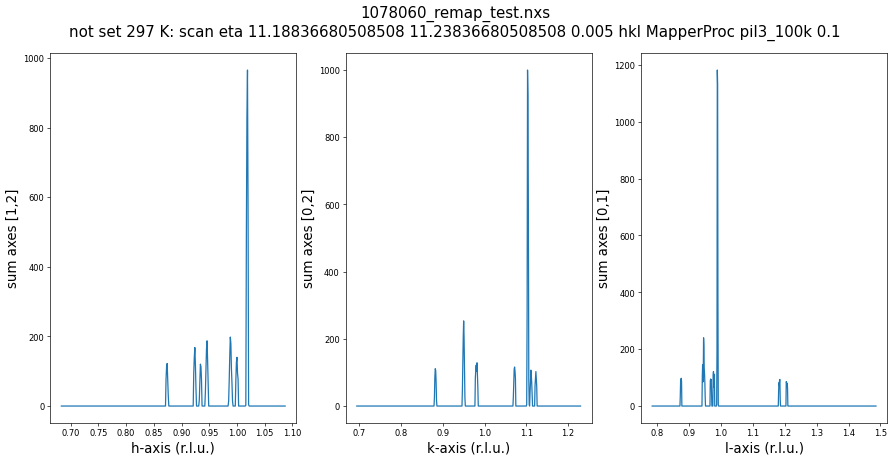

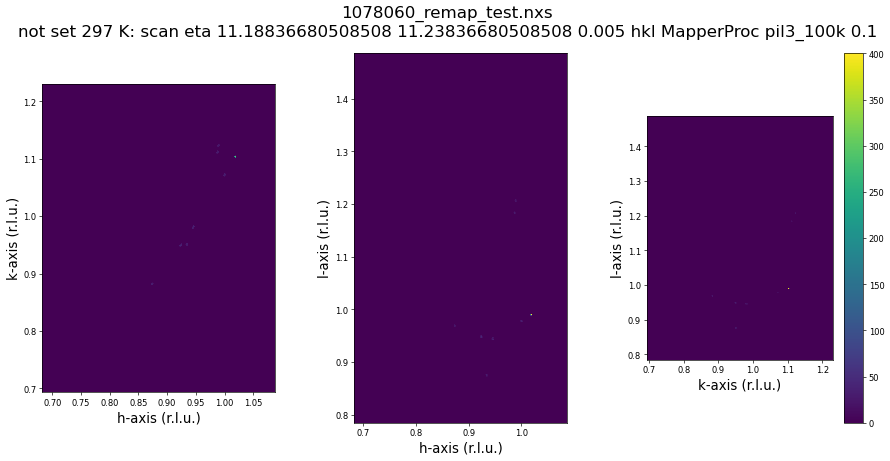

In [17]:
import h5py
filename = os.path.basename(outpath)

with h5py.File(outpath, 'r') as hdf:
    # the following are links to the original scan file
    scan_command = hdf['/entry0/scan_command'].asstr()[()]  # str
    crystal = hdf['/entry0/sample/name'].asstr()[()]  # str
    temp = hdf['/entry0/instrument/temperature_controller/Tsample'][()]  # float
    unit_cell = np.reshape(hdf['/entry0/sample/unit_cell'], -1)  # 1D array, length 6
    energy = hdf['/entry0/sample/beam/incident_energy'][()]  # # float
    ubmatrix = hdf['/entry0/sample/ub_matrix'][0]  # 3D array, shape (3,3)
    # this is the processed data
    haxis = hdf['/processed/reciprocal_space/h-axis'][()]  # 1D array, length n
    kaxis = hdf['/processed/reciprocal_space/k-axis'][()]  # 1D array, length m
    laxis = hdf['/processed/reciprocal_space/l-axis'][()]  # 1D array, length o
    volume = hdf['/processed/reciprocal_space/volume'][()]  # 3D array, shape [n,m,o]
    # detector parameters
    pixel_size = hdf['/entry0/instrument/pil3_100k/module/fast_pixel_direction'][()] # float, mm
    detector_distance = hdf['/entry/instrument/pil3_100k/transformations/origin_offset'][()] # float, mm

print(f"Loaded file: {filename} with volume shape: {volume.shape}")

# average angle subtended by each pixel
solid_angle = pixel_size ** 2 / detector_distance ** 2  # sr
print(f'Each pixel is normalised by the solid angle: {solid_angle: .4g} sr')

volume = volume * solid_angle

# Plot summed cuts
plt.figure(figsize=[18, 8], dpi=60)
title = f"{filename} '{crystal}' {temp:.3g} K\n{scan_command}"
plt.suptitle(title, fontsize=18)

plt.subplot(131)
plt.plot(haxis, volume.sum(axis=1).sum(axis=1))
plt.xlabel('h-axis (r.l.u.)', fontsize=16)
plt.ylabel('sum axes [1,2]', fontsize=16)

plt.subplot(132)
plt.plot(kaxis, volume.sum(axis=0).sum(axis=1))
plt.xlabel('k-axis (r.l.u.)', fontsize=16)
plt.ylabel('sum axes [0,2]', fontsize=16)

plt.subplot(133)
plt.plot(laxis, volume.sum(axis=0).sum(axis=0))
plt.xlabel('l-axis (r.l.u.)', fontsize=16)
plt.ylabel('sum axes [0,1]', fontsize=16)

# Plot summed images
plt.figure(figsize=[18, 8], dpi=60)
title = f"{filename}\n{crystal} {temp:.3g} K: {scan_command}"
plt.suptitle(title, fontsize=20)
plt.subplots_adjust(wspace=0.3)

plt.subplot(131)
K, H = np.meshgrid(kaxis, haxis)
plt.pcolormesh(H, K, volume.sum(axis=2), shading='auto')
plt.xlabel('h-axis (r.l.u.)', fontsize=16)
plt.ylabel('k-axis (r.l.u.)', fontsize=16)
plt.axis('image')
#plt.colorbar()

plt.subplot(132)
L, H = np.meshgrid(laxis, haxis)
plt.pcolormesh(H, L, volume.sum(axis=1), shading='auto')
plt.xlabel('h-axis (r.l.u.)', fontsize=16)
plt.ylabel('l-axis (r.l.u.)', fontsize=16)
plt.axis('image')
#plt.colorbar()

plt.subplot(133)
L, K = np.meshgrid(laxis, kaxis)
plt.pcolormesh(K, L, volume.sum(axis=0), shading='auto')
plt.xlabel('k-axis (r.l.u.)', fontsize=16)
plt.ylabel('l-axis (r.l.u.)', fontsize=16)
plt.axis('image')
plt.colorbar()

plt.show()

# NXtransformations
code taken from https://github.com/DanPorter/i16_diffractometer 

In [26]:
from typing import List, Tuple


def photon_wavelength(energy_kev):
    """
    Converts energy in keV to wavelength in A
     wavelength_a = photon_wavelength(energy_kev)
     lambda [A] = h*c/E = 12.3984 / E [keV]
    """
    return 12.3984 / energy_kev


def photon_energy(wavelength_a):
    """
    Converts wavelength in A to energy in keV
     energy_kev = photon_energy(wavelength_a)
     Energy [keV] = h*c/L = 12.3984 / lambda [A]
    """
    return 12.3984 / wavelength_a


def wavevector(wavelength_a):
    """Return wavevector = 2pi/lambda"""
    return 2 * np.pi / wavelength_a


def bmatrix(a, b=None, c=None, alpha=90., beta=90., gamma=90.):
    """
    Calculate the B matrix as defined in Busing&Levy Acta Cyst. 22, 457 (1967)
    Creates a matrix to transform (hkl) into a cartesian basis:
        (qx,qy,qz)' = B.(h,k,l)'       (where ' indicates a column vector)
     
    The B matrix is related to the reciprocal basis vectors:
        (astar, bstar, cstar) = 2 * np.pi * B.T
    Where cstar is defined along the z axis

    The B matrix is related to the real-space unit vectors:
        (A, B, C) = B^-1 = inv(B)
 
    :param a: lattice parameter a in Anstroms
    :param b: lattice parameter b in Anstroms
    :param c: lattice parameter c in Anstroms
    :param alpha: lattice angle alpha in degrees
    :param beta: lattice angle beta in degrees
    :param gamma: lattice angle gamma in degrees
    :returns: [3x3] array B matrix in inverse-Angstroms (no 2pi)
    """
    if b is None:
        b = a
    if c is None:
        c = a
    alpha1 = np.deg2rad(alpha)
    alpha2 = np.deg2rad(beta)
    alpha3 = np.deg2rad(gamma)
 
    beta1 = np.arccos((np.cos(alpha2)*np.cos(alpha3)-np.cos(alpha1))/(np.sin(alpha2)*np.sin(alpha3)))
    beta2 = np.arccos((np.cos(alpha1)*np.cos(alpha3)-np.cos(alpha2))/(np.sin(alpha1)*np.sin(alpha3)))
    beta3 = np.arccos((np.cos(alpha1)*np.cos(alpha2)-np.cos(alpha3))/(np.sin(alpha1)*np.sin(alpha2)))
 
    b1 = 1 / (a * np.sin(alpha2) * np.sin(beta3))
    b2 = 1 / (b * np.sin(alpha3) * np.sin(beta1))
    b3 = 1 / (c * np.sin(alpha1) * np.sin(beta2))
 
    c1 = b1 * b2 * np.cos(beta3)
    c2 = b1 * b3 * np.cos(beta2)
    c3 = b2 * b3 * np.cos(beta1)
 
    bm = np.array([
        [b1, b2 * np.cos(beta3), b3 * np.cos(beta2)],
        [0, b2 * np.sin(beta3), -b3 * np.sin(beta2)*np.cos(alpha1)],
        [0, 0, 1/c]
    ])
    return bm 


def norm_vector(vector, min_mag=0.001):
    mag = np.linalg.norm(vector)
    if mag < min_mag:
        mag = 1.
    return np.divide(vector, mag)


def rot_matrix(angle_rad: float, axis=(0, 0, 1)):
    """
    Generate rotation matrix about arbitary axis
    https://en.wikipedia.org/wiki/Rotation_matrix#Rotation_matrix_from_axis_and_angle
    """
    axis = norm_vector(axis)
    ux, uy, uz = axis
    c = np.cos(angle_rad)
    s = np.sin(angle_rad)
    c1 = 1 - c
    r = np.array([
        [
            (ux * ux * c1) + c,
            (uy * ux * c1) - uz * s,
            (uz * ux * c1) + uy * s
        ],
        [
            (ux * uy * c1) + uz * s,
            (uy * uy * c1) + c,
            (uz * uy * c1) - ux * s,
        ],
        [
            (ux * uz * c1) - uy * s,
            (uy * uz * c1) + ux * s,
            (uz * uz * c1) + c,
        ]
    ])
    return r


def rotation_t_matrix(value=0.0, vector=(0, 0, 1), offset=(0, 0, 0)):
    """
    Create 4x4 transformation matrix including a rotation
    """
    t = np.eye(4)
    t[:3, :3] = rot_matrix(angle_rad=value, axis=vector)
    t[:3, 3] = offset
    return t


def translation_t_matrix(value=0.0, vector=(0, 0, 1), offset=(0, 0, 0)):
    """
    Create 4x4 transformation matrix including a translation
    """
    t = np.eye(4)
    translation = value * np.reshape(vector, 3) + np.reshape(offset, 3)
    t[:3, 3] = translation
    return t


def rotate_by_matrix(xyz, angle_deg=0.0, axis=(0, 0, 1)):
    r = rot_matrix(np.deg2rad(angle_deg), axis)
    xyz = np.reshape(xyz, (-1, 3))
    return np.dot(r, xyz.T).T


def transform_by_t_matrix(xyz, t_matrix):
    xyz = np.reshape(xyz, (-1, 3))
    return (np.dot(t_matrix[:3, :3], xyz.T) + t_matrix[:3, 3:]).T


####### nexus_transformations.py ########


METERS = {  # conversion to meters
    'km': 1e3, 'm': 1, 'cm': 0.1, 'mm': 1e-3,
    'um': 1e-6, 'μm': 1e-6, 'nm': 1e-9,
    'A': 1e-10, 'Å': 1e-10
}

NX_CLASS = 'NX_class'
NX_DEFAULT = 'default'
NX_DEPON = 'depends_on'
NX_VECTOR = 'vector'
NX_OFFSET = 'offset'
NX_TTYPE = 'transformation_type'
NX_TROT = 'rotation'
NX_TTRAN = 'translation'
NX_UNITS = 'units'
NX_WL = 'incident_wavelength'
NX_EN = 'incident_energy'
NX_ENTRY = 'NXentry'
NX_INST = 'NXinstrument'
NX_DET = 'NXdetector'
NX_SAMPLE = 'NXsample'
NX_MODULE = 'NXdetector_module'
NX_BEAM = 'NXbeam'
NX_SAMPLE_NAME = 'name'
NX_SAMPLE_UC = 'unit_cell'
NX_SAMPLE_OM = 'orientation_matrix'
NX_SAMPLE_UB = 'ub_matrix'
NX_MODULE_ORIGIN = 'data_origin'
NX_MODULE_SIZE = 'data_size'
NX_MODULE_OFFSET = 'module_offset'
NX_MODULE_FAST = 'fast_pixel_direction'
NX_MODULE_SLOW = 'slow_pixel_direction'


def check_nexus_class(hdf_group: h5py.Group, nxclass: str) -> bool:
    """
    Check if hdf_group is a certain NX_class
    :param hdf_group: hdf or nexus group object
    :param nxclass: str name in NX_class attribute
    :return: True/False
    """
    return (hdf_group and
            (group_class := hdf_group.attrs.get(NX_CLASS)) is not None and
            (group_class.decode() if isinstance(group_class, bytes) else group_class) == nxclass)


def nx_first_nxclass(group: h5py.File | h5py.Group, nxclass: str) -> str:
    """
    Find first object within group that has correct NX_class attribute
    :param group:
    :param nxclass:
    :return:
    """
    if NX_DEFAULT in group.attrs and check_nexus_class(group.get(path := group.attrs[NX_DEFAULT]), nxclass):
        return path.decode() if isinstance(path, bytes) else path
    return next(path for path in group if check_nexus_class(group.get(path), nxclass))


def get_depends_on(path: str, hdf_file: h5py.File) -> str:
    """
    Returns 'depends_on' path from this group or dataset
    The returned path will point to a dataset, based on NeXus rules
    :param path:
    :return:
    """
    obj = hdf_file[path]
    if NX_DEPON in obj.attrs:
        do_path = obj.attrs[NX_DEPON]
    elif isinstance(obj, h5py.Group) and NX_DEPON in obj:
        do_path = obj[NX_DEPON][()]
    else:
        return '.'

    if do_path in hdf_file:
        return do_path.decode() if isinstance(do_path, bytes) else do_path
    # walk up tree to find relative file path
    while (isinstance(obj, h5py.Dataset) or do_path not in obj) and obj != obj.file:
        obj = obj.parent
    return obj[do_path].name if do_path in obj else '.'


def get_dataset_value(path: str, group: h5py.Group | h5py.File, default):
    """
    Get value from dataset in group, or return default
    :param path: hdf path of dataset in group
    :param group: hdf group
    :param default: returned if path doesn't exist
    :return: group[path][()]
    """
    if path in group:
        dataset = group[path]
        if np.issubdtype(dataset, np.number):
            return np.squeeze(dataset[()])
        return dataset.asstr()[()]
    return default


def nx_depends_on_chain(path: str, hdf_file: h5py.File) -> List[str]:
    """
    Returns list of paths in a transformation chain, linked by 'depends_on'
    :param path: hdf path of initial dataset or group
    :param hdf_file: Nexus file object
    :return:
    """
    depends_on = get_depends_on(path, hdf_file)
    out = []
    if depends_on != '.':
        out.append(depends_on)
        out.extend(nx_depends_on_chain(depends_on, hdf_file))
    return out


def nx_direction(path: str, hdf_file: h5py.File) -> np.ndarray:
    """
    Return a unit-vector direction from a dataset
    :param path: hdf path of NXtransformation path or component group with 'depends_on'
    :param hdf_file: Nexus file object
    :return: unit-vector array
    """
    depends_on = get_depends_on(path, hdf_file)
    if depends_on == '.':
        dataset = hdf_file[path]
    else:
        dataset = hdf_file[depends_on]

    vector = np.asarray(dataset.attrs.get(NX_VECTOR, (0, 0, 0)))
    return norm_vector(vector)


def nx_transformations_max_size(path: str, hdf_file: h5py.File) -> int:
    """
    Return the maximum dataset size from a chain of transformations
    :param path: hdf dataset path of NX transformation, or group containing 'depends_on'
    :param hdf_file: Nexus file object
    :return: int : largest dataset.size
    """
    dataset = hdf_file[path]
    dataset_size = dataset.size if isinstance(dataset, h5py.Dataset) else 0
    depends_on = get_depends_on(path, hdf_file)
    if depends_on != '.':
        size = nx_transformations_max_size(depends_on, hdf_file)
        return size if size > dataset_size else dataset_size
    return dataset_size


def nx_transformations(path: str, index: int, hdf_file: h5py.File, print_output=False) -> List[np.ndarray]:
    """
    Create list of 4x4 transformation matrices matching transformations along an NXtransformations chain
    :param path: str hdf path of the first point in the chain (Group or Dataset)
    :param index: int index of point in scan
    :param hdf_file: Nexus file object
    :param print_output: bool, if true the operations will be printed
    :return: list of 4x4 arrays [T1, T2, T3, ... Tn]
    """
    dataset = hdf_file[path]
    depends_on = get_depends_on(path, hdf_file)
    if print_output:
        print(f"{dataset}, depends on: {depends_on}")

    if isinstance(dataset, h5py.Group):
        return nx_transformations(depends_on, index, hdf_file, print_output)

    this_index = index if dataset.size > 1 else 0
    value = dataset[np.unravel_index(this_index, dataset.shape)]

    transformation_type = dataset.attrs.get(NX_TTYPE, b'').decode()
    vector = np.array(dataset.attrs.get(NX_VECTOR, (1, 0, 0)))
    offset = dataset.attrs.get(NX_OFFSET, (0, 0, 0))
    units = dataset.attrs.get(NX_UNITS, b'').decode()

    if transformation_type == NX_TROT:
        if print_output:
            print(f"Rotating about {vector} by {value} {units}  | {path}")
        if units == 'deg':
            value = np.deg2rad(value)
        elif units != 'rad':
            value = np.deg2rad(value)
            print(f"Warning: Incorrect rotation units: '{units}'")
        matrix = rotation_t_matrix(value, vector, offset)
    elif transformation_type == NX_TTRAN:
        if print_output:
            print(f"Translating along {vector} by {value} {units}  | {path}")
        if units in METERS:
            unit_multiplier = METERS[units]
        else:
            unit_multiplier = 1.0
            print(f"Warning: unknown translation untis: {units}")
        value = value * unit_multiplier * 1000  # distance in mm
        matrix = translation_t_matrix(value, vector, offset)
    else:
        if print_output:
            print(f"transformation type of '{path}' not recognized: '{transformation_type}'")
        matrix = np.eye(4)

    if depends_on == '.':  # end chain
        return [matrix]
    return [matrix] + nx_transformations(depends_on, index, hdf_file, print_output)


def nx_transformations_matrix(path: str, index: int, hdf_file: h5py.File) -> np.ndarray:
    """
    Combine chain of transformation operations into single matrix
    :param path: str hdf path of the first point in the chain (Group or Dataset)
    :param index: int index of point in scan
    :param hdf_file: Nexus file object
    :return: 4x4 array
    """
    matrices = nx_transformations(path, index, hdf_file)
    # Combine the transformations in reverse
    return np.linalg.multi_dot(matrices[::-1])  # multiply transformations Tn..T3.T2.T1


def nx_transform_vector(xyz, path: str, index: int, hdf_file: h5py.File) -> np.ndarray:
    """
    Transform a vector or position [x, y, z] by an NXtransformations chain
    :param xyz: 3D coordinates, n*3 [[x, y, z], ...]
    :param path: hdf path of first object in NXtransformations chain
    :param index: int index of point in scan
    :param hdf_file: Nexus file object
    :return: n*3 array([[x, y, z], ...]) transformed by operations
    """
    xyz = np.reshape(xyz, (-1, 3))
    t_matrix = nx_transformations_matrix(path, index, hdf_file)
    return (np.dot(t_matrix[:3, :3], xyz.T) + t_matrix[:3, 3:]).T


def nx_beam_energy(beam: h5py.Group):
    """
    Return beam energy in keV and wavelength in A
    :param beam: Nexus NXbeam group
    :return: incident_energy, incident_wavelength
    """
    if NX_WL in beam:
        dataset = beam[NX_WL]
        units = dataset.attrs.get(NX_UNITS, b'nm').decode()
        wl = dataset[()]
        if units.lower() in METERS:
            wl = wl * METERS[units] * 1e-10  # wavelength in Angstroms
        else:
            print(f"Warning: unknown translation untis: {units}")
        return photon_energy(wl), wl
    elif NX_EN in beam:
        dataset = beam[NX_WL]
        units = dataset.attrs.get(NX_UNITS, b'ev').decode()
        en = dataset[()]
        if units.lower() == 'ev':
            en = en / 1000.  # wavelength in keV
        return en, photon_wavelength(en)
    else:
        raise KeyError(f"{beam} contains no '{NX_WL}' or '{NX_EN}'")


###########################################################################
###########################################################################
###########################################################################


class NXBeam:
    """
    NXbeam object
    """
    def __init__(self, path: str, hdf_file: h5py.File):
        self.file = hdf_file
        self.path = path
        self.beam = hdf_file[path]

        self.direction = nx_direction(path, hdf_file)
        self.en, self.wl = self.energy_wavelength()
        self.wv = wavevector(self.wl)
        self.incident_wavevector = self.wv * self.direction

    def energy_wavelength(self):
        """
        Return beam energy in keV and wavelength in A
        :return: incident_energy, incident_wavelength
        """
        if NX_WL in self.beam:
            dataset = self.beam[NX_WL]
            units = dataset.attrs.get(NX_UNITS, b'nm').decode()
            wl = dataset[()]
            if units == 'nm':
                wl = 10 * wl  # wavelength in Angstroms
            return photon_energy(wl), wl
        elif NX_EN in self.beam:
            dataset = self.beam[NX_WL]
            units = dataset.attrs.get(NX_UNITS, b'ev').decode()
            en = dataset[()]
            if units.lower() == 'ev':
                en = en / 1000.  # wavelength in keV
            return en, photon_wavelength(en)
        else:
            raise KeyError(f"{self.beam} contains no '{NX_WL}' or '{NX_EN}'")

    def __repr__(self):
        return f"NXBeam({self.beam})"


class NXSsample:
    """
    NXsample object
    """
    def __init__(self, path: str, hdf_file: h5py.File):
        self.file = hdf_file
        self.path = path
        self.sample = hdf_file[path]

        self.name = get_dataset_value(NX_SAMPLE_NAME, self.sample, 'none')
        self.unit_cell = get_dataset_value(NX_SAMPLE_UC, self.sample, np.array([1., 1, 1, 90, 90, 90]))
        self.orientation_matrix = get_dataset_value(NX_SAMPLE_OM, self.sample, np.eye(3))
        self.ub_matrix = get_dataset_value(NX_SAMPLE_UB, self.sample, bmatrix(*self.unit_cell))

        self.size = nx_transformations_max_size(path, hdf_file)
        self.transforms = [
            nx_transformations_matrix(path, n, hdf_file)
            for n in range(self.size)
        ]  # list of 4x4 transformation matrices

    def __repr__(self):
        return f"NXSsample({self.sample})"

    def hkl2q(self, hkl: Tuple[float, float, float] | np.ndarray):
        """
        Returns wavecector direction for given hkl
        :param hkl: Miller indices, in units of reciprocal lattice vectors
        :return: Q position in inverse Angstroms
        """
        hkl = np.reshape(hkl, (-1, 3))
        z = self.transforms[0][:3, :3]
        ub = 2 * np.pi * self.ub_matrix
        return np.dot(z, np.dot(ub, hkl.T)).T


class NXDetectorModule:
    """
    NXdetector_module object
    """
    def __init__(self, path: str, hdf_file: h5py.File):
        self.file = hdf_file
        self.path = path
        self.module = hdf_file[path]

        self.data_origin = get_dataset_value(NX_MODULE_ORIGIN, self.module, np.array([0, 0]))
        self.data_size = get_dataset_value(NX_MODULE_SIZE, self.module, np.array([1, 1]))

        self.module_offset_path = f"{self.path}/{NX_MODULE_OFFSET}"
        self.fast_pixel_direction_path = f"{self.path}/{NX_MODULE_FAST}"
        self.slow_pixel_direction_path = f"{self.path}/{NX_MODULE_SLOW}"

        self.size = nx_transformations_max_size(self.module_offset_path, hdf_file)
        self.offset_transforms = [
            nx_transformations_matrix(self.module_offset_path, n, hdf_file)
            for n in range(self.size)
        ]  # list of 4x4 transformation matrices
        self.fast_transforms = [
            nx_transformations_matrix(self.fast_pixel_direction_path, n, hdf_file)
            for n in range(self.size)
        ]  # list of 4x4 transformation matrices
        self.slow_transforms = [
            nx_transformations_matrix(self.slow_pixel_direction_path, n, hdf_file)
            for n in range(self.size)
        ]  # list of 4x4 transformation matrices

    def __repr__(self):
        return f"NXDetectorModule({self.module})"

    def shape(self):
        """
        Return scan shape of module
            (n, i, j)
        Where:
            n = frames in scan
            i = pixels along slow axis
            j = pixels along fast axis
        """
        return self.size, self.data_size[0], self.data_size[1]

    def pixel_wavevector(self, point: Tuple[int, int, int], wavelength_a) -> np.ndarray:
        """
        Return wavevector of pixel
        :param point: (n, i, j) == (frame, slow_axis_pixel, fast_axis_pixel)
        :param wavelength_a: wavelength in Angstrom
        :return: [dx, dy, dz] unit vector
        """
        return wavevector(wavelength_a) * self.pixel_direction(point)

    def pixel_direction(self, point: Tuple[int, int, int]) -> np.ndarray:
        """
        Return direction of pixel
        :param point: (n, i, j) == (frame, slow_axis_pixel, fast_axis_pixel)
        :return: [dx, dy, dz] unit vector
        """
        return norm_vector(self.pixel_position(point))

    def pixel_position(self, point: Tuple[int, int, int]) -> np.ndarray:
        """
        Return position of pixel (n, i, j)
            n = frame in scan
            i = pixel along slow axis
            j = pixel along fast axis
        """
        index, ii, jj = point

        module_origin = transform_by_t_matrix([0, 0, 0], self.offset_transforms[index])
        fast_pixel = transform_by_t_matrix([0, 0, 0], self.fast_transforms[index])
        slow_pixel = transform_by_t_matrix([0, 0, 0], self.slow_transforms[index])

        fast_direction = fast_pixel - module_origin
        slow_direction = slow_pixel - module_origin
        return np.squeeze(ii * slow_direction + jj * fast_direction + module_origin)

    def corners(self, frame: int) -> np.ndarray:
        shape = self.shape()
        corners = np.vstack([
            self.pixel_position((frame, 0, 0)),  # module origin
            self.pixel_position((frame, int(shape[1]), 0)),  # module origin + slow pixels
            self.pixel_position((frame, int(shape[1]), int(shape[2]))),  # o + slow + fast
            self.pixel_position((frame, 0, int(shape[2]))),  # o + fast
            self.pixel_position((frame, 0, 0)),  # module origin
        ])
        return corners


class NXDetector:
    """
    NXdetector object
    """
    def __init__(self, path: str, hdf_file: h5py.File):
        self.file = hdf_file
        self.path = path
        self.detector = hdf_file[path]
        self.size = nx_transformations_max_size(path, hdf_file)
        self.position = nx_transform_vector((0, 0, 0), path, self.size // 2, hdf_file).squeeze()

        self.modules = [
            NXDetectorModule(f"{self.path}/{p}", hdf_file)
            for p, obj in self.detector.items()
            if obj.attrs.get(NX_CLASS) == NX_MODULE.encode()
        ]

    def __repr__(self):
        return f"NXDetector({self.detector}) with {len(self.modules)} modules"


class NXScan:
    """
    NXScan object
    """
    def __init__(self, hdf_file: h5py.File):
        self.file = hdf_file

        self.entry = hdf_file[nx_first_nxclass(hdf_file, NX_ENTRY)]
        self.instrument = self.entry[nx_first_nxclass(self.entry, NX_INST)]

        self.detectors = [
            NXDetector(f"{self.instrument.name}/{p}", hdf_file)
            for p, obj in self.instrument.items()
            if obj.attrs.get(NX_CLASS) == NX_DET.encode()
        ]
        self.components = [
            obj for obj in self.instrument.values()
            if isinstance(obj, h5py.Group) and 'depends_on' in obj
        ]
        self.component_positions = {
            obj.name.split('/')[-1]: nx_transform_vector((0, 0, 0), obj.name, 0, hdf_file).squeeze()
            for obj in self.components
        }
        self.component_positions['sample'] = np.array([0, 0, 0])

        sample_obj = self.entry[nx_first_nxclass(self.entry, NX_SAMPLE)]
        self.sample = NXSsample(sample_obj.name, hdf_file)
        beam_obj = sample_obj[nx_first_nxclass(sample_obj, NX_BEAM)]
        self.beam = NXBeam(beam_obj.name, hdf_file)

    def __repr__(self):
        return f"NXScan({self.file})"

    def shape(self):
        detector_module = self.detectors[0].modules[0]
        return detector_module.shape()

    def detector_q(self, point: Tuple[int, int, int] = (0, 0, 0)):
        wavelength = self.beam.wl
        ki = self.beam.incident_wavevector
        detector_module = self.detectors[0].modules[0]
        kf = detector_module.pixel_wavevector(point, wavelength)
        return kf - ki

    def hkl(self, point: Tuple[int, int, int] = (0, 0, 0)):
        q = self.detector_q(point)
        z = self.sample.transforms[point[0]][:3, :3]
        ub = 2 * np.pi * self.sample.ub_matrix

        inv_ub = np.linalg.inv(ub)
        inv_z = np.linalg.inv(z)

        hphi = np.dot(inv_z, q)
        return np.dot(inv_ub, hphi).T

    def hkl2q(self, hkl: Tuple[float, float, float] | np.ndarray):
        """
        Returns wavecector direction for given hkl
        :param hkl: Miller indices, in units of reciprocal lattice vectors
        :return: Q position in inverse Angstroms
        """
        return self.sample.hkl2q(hkl)

    def plot_instrument(self, figsize=[16, 6], dpi=100):
        fig = plt.figure(figsize=figsize, dpi=dpi)
        ax = fig.add_subplot(projection='3d')

        instrument_name = get_dataset_value('name', self.instrument, 'no name')
        max_distance = max([np.linalg.norm(position) for position in self.component_positions.values()])
        max_position = max_distance * self.beam.direction

        ax.plot([-max_position[0], 0], [-max_position[2], 0], [-max_position[1], 0], 'k-')  # beam
        beam_cont = np.linalg.norm(self.detectors[0].position) * self.beam.direction
        ax.plot([0, beam_cont[0]], [0, beam_cont[2]], [0, beam_cont[1]], 'k:')  # continued beam
        # detectors
        for detector in self.detectors:
            pos = detector.position
            ax.plot([0, pos[0]], [0, pos[2]], [0, pos[1]], 'k-')  # scattered beam
        # components
        for component, position in self.component_positions.items():
            ax.plot(position[0], position[2], position[1], 'r+')
            ax.text(position[0], position[2], position[1], s=component)

        ax.set_xlabel('X [mm]')
        ax.set_ylabel('Z [mm]')
        ax.set_zlabel('Y [mm]')
        ax.set_title(instrument_name)
        # ax.set_aspect('equalxz')
        fig.show()

    def plot_wavevectors(self, figsize=[16, 6], dpi=100):
        fig = plt.figure(figsize=figsize, dpi=dpi)
        ax = fig.add_subplot(projection='3d')

        pixel_centre = tuple([i // 2 for i in self.shape()])
        ki = self.beam.incident_wavevector
        detector_module = self.detectors[0].modules[0]
        kf = detector_module.pixel_wavevector(pixel_centre, self.beam.wl)
        q = kf - ki

        ax.plot([-ki[0], 0], [-ki[2], 0], [-ki[1], 0], '-k')
        ax.plot([0, kf[0]], [0, kf[2]], [0, kf[1]], '-k')
        ax.plot([0, q[0]], [0, q[2]], [0, q[1]], '-r')

        shape = self.shape()
        wl = self.beam.wl
        for frame in range(shape[0]):
            corners = np.vstack([
                detector_module.pixel_wavevector((frame, 0, 0), wl),  # module origin
                detector_module.pixel_wavevector((frame, shape[1], 0), wl),  # module origin + slow pixels
                detector_module.pixel_wavevector((frame, shape[1], shape[2]), wl),  # o + slow + fast
                detector_module.pixel_wavevector((frame, 0, shape[2]), wl),  # o + fast
                detector_module.pixel_wavevector((frame, 0, 0), wl),  # module origin
            ])
            ax.plot(corners[:, 0], corners[:, 2], corners[:, 1], '-k')
            corners_q = corners - ki
            ax.plot(corners_q[:, 0], corners_q[:, 2], corners_q[:, 1], '-r')

        # plot Reciprocal lattice
        astar, bstar, cstar = self.hkl2q(np.eye(3))
        ax.plot([0, astar[0]], [0, astar[2]], [0, astar[1]], '-g')
        ax.plot([0, bstar[0]], [0, bstar[2]], [0, bstar[1]], '-g')
        ax.plot([0, cstar[0]], [0, cstar[2]], [0, cstar[1]], '-g')
        ax.text(astar[0], astar[2], astar[1], s='a*')
        ax.text(bstar[0], bstar[2], bstar[1], s='b*')
        ax.text(cstar[0], cstar[2], cstar[1], s='c*')

        ax.set_xlabel('X')
        ax.set_ylabel('Z')
        ax.set_zlabel('Y')
        ax.set_title(f"HKL: {self.hkl(pixel_centre)}")
        ax.set_aspect('equal')
        fig.show()

    def plot_hkl(self, figsize=[16, 6], dpi=100):
        fig = plt.figure(figsize=figsize, dpi=dpi)
        ax = fig.add_subplot(projection='3d')

        shape = self.shape()
        pixel_centre = tuple([i // 2 for i in shape])
        for frame in range(shape[0]):
            corners = np.vstack([
                self.hkl((frame, 0, 0)),  # module origin
                self.hkl((frame, shape[1], 0)),  # module origin + slow pixels
                self.hkl((frame, shape[1], shape[2])),  # o + slow + fast
                self.hkl((frame, 0, shape[2])),  # o + fast
                self.hkl((frame, 0, 0)),  # module origin
            ])
            ax.plot(corners[:, 0], corners[:, 2], corners[:, 1], '-r')
        origin = self.hkl((0, 0, 0))
        ax.plot(origin[0], origin[2], origin[1], '+k')

        ax.set_xlabel('H')
        ax.set_ylabel('L')
        ax.set_zlabel('K')
        ax.set_title(f"HKL: {self.hkl(pixel_centre)}")
        ax.set_aspect('equal')
        fig.show()



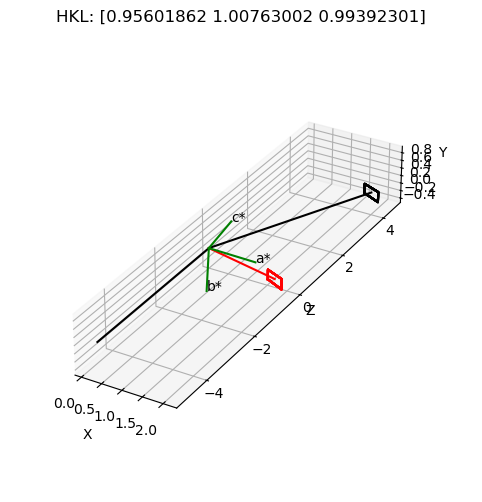

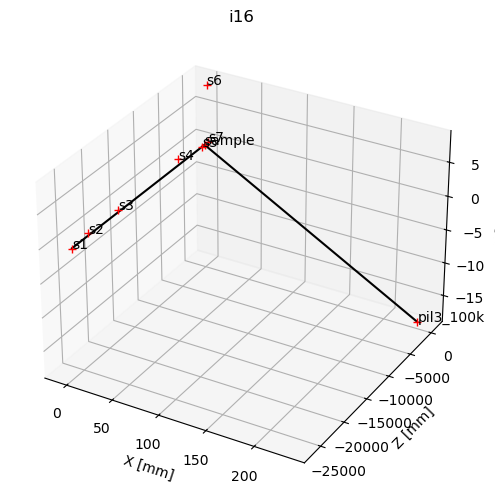

In [27]:
# plot reciprocal space and instrument positions from NXtransformations
with h5py.File(inpath) as nxs:
    scan = NXScan(nxs)
    scan.plot_wavevectors()

    scan.plot_instrument()

    plt.show()